# **Machine Learning: Project Part 2**

---

**Author: Damien Farrell**

---

## **Project Part 2: Seal Call Discrimination**

### **Objective**
The aim of this project is to analyze a recorded dataset to investigate the feasibility of discriminating between different seal calls. The project is structured in steps to build a machine learning model that can potentially detect seal calls from audio recordings. While creating a fully functional detector is the ultimate goal, it may not be the final outcome of this project.

#### **Step A: Data Pre-processing**

This step is completed in notebook `data_preprocessing.ipynb`. The file `processed_data.pkl` was produced from this notebook.

#### **Step B: Model Training**
1. **Dataset Utilisation**:
   - Use the prepared spectrogram dataset to train the machine learning model.

3. **Evaluation**:
   - Test the model’s performance on a separate test dataset.

#### **Step C: Refine**
1. **Parameter Tuning**:
   - Adjust parameters in the data extraction/spectrogram creation process (e.g., `nfft`, `noverlap`).
   - Manage computational costs by splitting `.wav` files using tools like `pydub`.

2. **Validation**:
   - Apply the Rupe B/No Call classifier on an entire `.wav` file (held back during training).
   - Ensure no false positives due to the presence of other annotated calls.

In [135]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

---

### **Step B: Model Training** 

---

In [136]:
# Load in processed data
df = pd.read_pickle('processed_data.pkl')
df

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),...,snippet_spectrogram,snippet_times,snippet_frequencies,Annotation_G Rupe,Annotation_Moan,Annotation_No Call,Annotation_Rupe A,Annotation_Rupe B,Annotation_Rupe C,Annotation_Type 4 A
0,1,Spectrogram 1,1,4.136987,4.657535,173.956,286.792,0.520500,112.836,-82.85,...,"[[10.569122314453125, 4.712647438049316, 1.273...","[4.131708333333333, 4.1445, 4.157291666666667,...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14...",True,False,False,False,False,False,False
1,2,Spectrogram 1,1,3.789955,4.264841,371.419,451.345,0.474900,79.926,-92.16,...,"[[42.39829635620117, 55.68126678466797, 83.361...","[3.7863333333333333, 3.799125, 3.8119166666666...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14...",True,False,False,False,False,False,False
2,3,Spectrogram 1,1,14.840188,15.406398,136.660,445.248,0.566200,308.588,-88.96,...,"[[29.341825485229492, 8.032623291015625, 43.69...","[14.838333333333333, 14.851125, 14.86391666666...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14...",True,False,False,False,False,False,False
3,4,Spectrogram 1,1,24.543802,25.082615,167.519,392.347,0.538800,224.828,-86.10,...,"[[0.28541040420532227, 0.41072168946266174, 2....","[24.547208333333334, 24.56, 24.572791666666667...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14...",True,False,False,False,False,False,False
4,5,Spectrogram 1,1,35.989220,36.573694,119.027,436.431,0.584500,317.405,-80.18,...,"[[13.951732635498047, 23.50061798095703, 20.28...","[35.982958333333336, 35.99575, 36.008541666666...","[23.4375, 46.875, 70.3125, 93.75, 117.1875, 14...",True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3723,None,None,None,1113.309917,1114.371625,NaN,NaN,1.061708,NaN,NaN,...,"[[0.011140447, 0.019048119, 0.005185865, 0.003...","[1113.3099166666666, 1113.3227083333334, 1113....",None,False,False,True,False,False,False,False
3724,None,None,None,755.232792,756.294500,NaN,NaN,1.061708,NaN,NaN,...,"[[0.0016650123, 0.001, 0.0024891268, 0.0017487...","[755.2327916666667, 755.2455833333333, 755.258...",None,False,False,True,False,False,False,False
3725,None,None,None,59.506833,60.568542,NaN,NaN,1.061708,NaN,NaN,...,"[[0.001, 0.0014154905, 0.002194438, 0.001, 0.0...","[59.50683333333333, 59.519625, 59.532416666666...",None,False,False,True,False,False,False,False
3726,None,None,None,250.895750,251.957458,NaN,NaN,1.061708,NaN,NaN,...,"[[0.0031127078, 0.002369191, 0.010698743, 0.00...","[250.89575, 250.90854166666668, 250.9213333333...",None,False,False,True,False,False,False,False


In [137]:
# Shuffle
df = shuffle(df)

# Get the shapes
shapes = df['snippet_spectrogram'].apply(lambda x: x.shape if isinstance(x, np.ndarray) else None)

# Count unique shapes
print("Unique shapes in 'snippet_spectrogram':")
print(shapes.value_counts())

Unique shapes in 'snippet_spectrogram':
snippet_spectrogram
(42, 84)    3728
Name: count, dtype: int64


In [138]:
X = df[['snippet_spectrogram']].to_numpy()

# "Flatten" the (3742, 1) array to (3742,)
X = X.ravel()
print(X.shape)

# Stack along a new axis to get shape (3742, 42, 84)
X = np.stack(X, axis=0)
print(X.shape)


(3728,)
(3728, 42, 84)


In [139]:
# Reshape to 2D for MinMaxScaler
X_reshaped = X.reshape(-1, X.shape[-2])  # Shape: (3742 * 42, 84)

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_reshaped)

# Reshape back to the original shape
X = X_scaled.reshape(X.shape)

X.shape

(3728, 42, 84)

In [140]:
from sklearn.model_selection import train_test_split

X = np.stack(df['snippet_spectrogram'].values)
y = df[[col for col in df.columns if col.startswith("Annotation_")]]  # Select annotation columns

# `y` contains one-hot encoded labels
stratify_labels = y.idxmax(axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=stratify_labels
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (2982, 42, 84) Test shape: (746, 42, 84)


In [141]:
stratify_labels

636      Annotation_G Rupe
3121    Annotation_No Call
555      Annotation_G Rupe
2576    Annotation_No Call
1958    Annotation_No Call
               ...        
2131    Annotation_No Call
1465     Annotation_Rupe A
120      Annotation_G Rupe
2449    Annotation_No Call
2892    Annotation_No Call
Length: 3728, dtype: object

In [142]:
num_classes = len(stratify_labels.unique())

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(42, 84, 1)))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))


In [143]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 42, 84, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 21, 42, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 21, 42, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 10, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 10, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 5, 10, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,927 (1.66 MB)

 Trainable params: 433,927 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [144]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  #from_logits=False as softmax is on the output of the CNN
    metrics=['accuracy'],
)

In [145]:
history = model.fit(X_train, y_train, epochs=40, validation_split=0.2)

Epoch 1/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6114 - loss: 16.0226 - val_accuracy: 0.5159 - val_loss: 1.2149
Epoch 2/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6008 - loss: 1.0418 - val_accuracy: 0.7119 - val_loss: 16.7980
Epoch 3/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7151 - loss: 3.4720 - val_accuracy: 0.7253 - val_loss: 13.9115
Epoch 4/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7753 - loss: 0.6132 - val_accuracy: 0.8358 - val_loss: 20.5088
Epoch 5/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8312 - loss: 0.4753 - val_accuracy: 0.8358 - val_loss: 16.6007
Epoch 6/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8673 - loss: 0.4110 - val_accuracy: 0.8710 - val_loss: 18.3612
Epoch 7/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8711 - loss: 0.3860 - val_accuracy: 0.8626 - val_loss: 19.1301
Epoch 8/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8842 - loss: 0.3534 - val_accuracy: 0.8911 - va

In [146]:
model.evaluate(X_test, y_test, return_dict=True)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9002 - loss: 63.3982 


{'accuracy': 0.9061661958694458, 'loss': 18.027740478515625}

In [147]:
def plot_loss(history, which='loss'):
    plt.plot(history.history[which], label='train')
    try:
        plt.plot(history.history['val_'+which], label='validation')
    except:
        None
    plt.xlabel('Epoch')
    plt.ylabel(which)
    plt.legend()
    plt.grid(True)

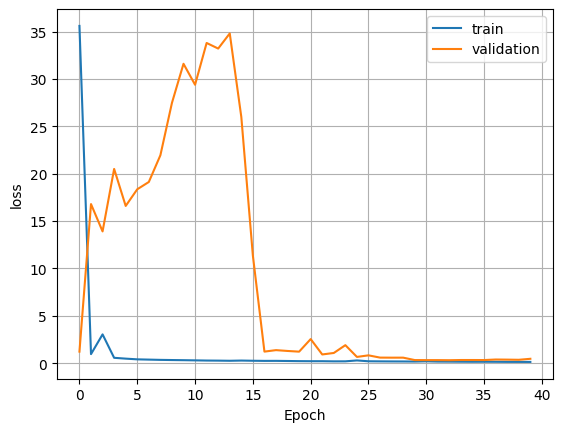

In [148]:
plot_loss(history)

#### **Early Stopping**

In [149]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [150]:
history = model.fit(X_train, y_train, epochs=40, validation_split=0.2)

Epoch 1/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9541 - loss: 0.1411 - val_accuracy: 0.9280 - val_loss: 0.3720
Epoch 2/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9551 - loss: 0.1356 - val_accuracy: 0.9380 - val_loss: 0.3838
Epoch 3/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9529 - loss: 0.1369 - val_accuracy: 0.9229 - val_loss: 0.4619
Epoch 4/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9313 - loss: 0.2030 - val_accuracy: 0.9447 - val_loss: 0.4587
Epoch 5/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9698 - loss: 0.1003 - val_accuracy: 0.9414 - val_loss: 0.4150
Epoch 6/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9591 - loss: 0.1223 - val_accuracy: 0.9313 - val_loss: 0.4478
Epoch 7/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9623 - loss: 0.1010 - val_accuracy: 0.9414 - val_loss: 0.4390
Epoch 8/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9589 - loss: 0.1128 - val_accuracy: 0.9079 - val_loss:

In [151]:
model.evaluate(X_test, y_test, return_dict=True)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9271 - loss: 0.2786


{'accuracy': 0.9316353797912598, 'loss': 0.27433252334594727}

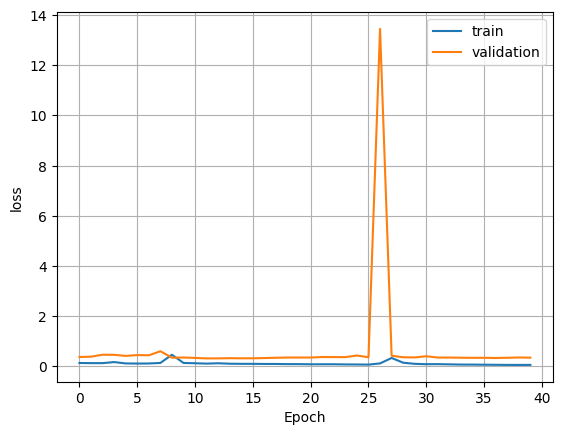

In [152]:
plot_loss(history)

In [153]:
model.evaluate(X_test, y_test, return_dict=True)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9271 - loss: 0.2786


{'accuracy': 0.9316353797912598, 'loss': 0.27433252334594727}

In [154]:
stratify_labels.value_counts()

Annotation_No Call     1864
Annotation_G Rupe       725
Annotation_Rupe A       502
Annotation_Moan         423
Annotation_Rupe B       166
Annotation_Rupe C        25
Annotation_Type 4 A      23
Name: count, dtype: int64

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


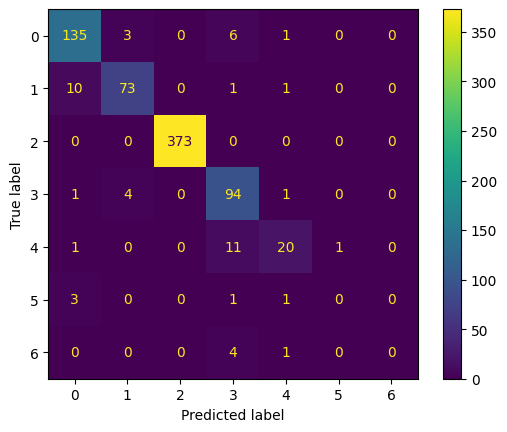

In [155]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert to class labels

# Convert y_test from one-hot to class labels
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(y_test.shape[1]))
disp.plot(cmap='viridis')


---

### **Step C: Refine**

---

---

### **References**

1. [Bird Song Dataset on Kaggle](https://www.kaggle.com/code/sophiagnetneva/cnn-for-sound-classification-bird-calls-90)





---

# END